In [1]:
from desc.compute.utils import get_transforms, get_profiles, get_params, dot
from desc.compute import compute as compute_fun
from desc.backend import jnp
from desc.grid import Grid, LinearGrid
import desc.io
import desc.examples
from functools import partial
from jax import jit
from jax.experimental.ode import odeint as jax_odeint
import matplotlib.pyplot as plt
import numpy as np
import time

# eq = desc.examples.get("DSHAPE")
eq = desc.io.load("equilibria/test_run.h5")
eq._iota = eq.get_profile("iota").to_powerseries(order=eq.L, sym=True)
eq._current = None
eq.solve()

def B_for_f_ratio_surface(psi_i):
    grid = LinearGrid(rho = np.sqrt(psi_i), M = 20, N = 20, NFP = eq.NFP)
    output = eq.compute("|B|", grid=grid)
    B = output["|B|"]
    return B

def B_for_f_ratio_fieldline(psi_i):
    coords = jnp.ones((250, 3)) #rho alpha zeta
    coords = coords.at[:, 0].set(coords[:, 0] * jnp.sqrt(psi_i))
    coords = coords.at[:, 2].set(jnp.linspace(0, 6 * jnp.pi, 250))

    start_time = time.time()
    print("starting map coords")
    print("--- %s seconds ---" % (time.time() - start_time))

    coords1 = eq.map_coordinates(
        coords=coords,
        inbasis=["rho", "alpha", "zeta"],
        outbasis=["rho", "theta", "zeta"],
        period=[jnp.inf, 2 * jnp.pi, jnp.inf],
        guess=None,
    )  # (2 * jnp.pi / eq.NFP)],

    grid = Grid(coords1, jitable=False, sort=False)
    output = eq.compute("|B|", grid=grid)

    B = output["|B|"]
    return B, coords1

def f_ratio(B):
    return np.sqrt(1-np.nanmin(B)/np.nanmax(B))




DESC version 0+untagged.5510.g707828e.dirty,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 2.72 GB available memory
Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 856
Number of objectives: 5346
Starting optimization
Using method: lsq-exact
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 2.734e-06
         Total delta_x: 6.469e-02
         Iterations: 5
         Function evaluations: 9
         Jacobian evaluations: 6
Start of solver
Total (sum of squares):  2.876e-06, 
Total force:  1.355e+05 (N)
Total force:  2.398e-03 (normalized)
End of solver
Total (sum of squares):  2.734e-06, 
Total force:  1.321e+05 (N)
Total force:  2.338e-03 (normalized)


In [2]:
def check(quantity, rho_i, theta_i, zeta_i):
    grid = Grid(jnp.array([rho_i, theta_i, zeta_i]).T, jitable=True, sort=False)
    output = eq.compute(quantity, grid=grid)
    return output[quantity]

# plot_3d(eq, "B")
val = check("grad(psi)", 1, 0, 0)[0]
print(val)

[ 1.57992279e+01 -3.24372694e-16  7.48118656e-16]


In [3]:
def system(w, t, a):
    #initial conditions
    psi, theta, zeta, vpar = w
    
    keys = ["B", "|B|", "grad(|B|)", "grad(psi)", "e^theta", "e^zeta", "b"] # etc etc, whatever terms you need
    grid = Grid(jnp.array([jnp.sqrt(psi), theta, zeta]).T, jitable=True, sort=False)
    transforms = get_transforms(keys, eq, grid, jitable=True)
    profiles = get_profiles(keys, eq, grid, jitable=True)
    params = get_params(keys, eq)
    data = compute_fun(eq, keys, params, transforms, profiles)
    
    mu, m_q, bound_psi = a
    print(mu)
    # print(m_q)
    # print(data["|B|"])
    # print(data["grad(|B|)"])

    aux = data["b"] + m_q*(mu/data["|B|"]**2) * jnp.cross(data["B"], data["grad(|B|)"], axis=-1)/vpar
    # print(aux)

    psidot = m_q*(1/(data["|B|"]**3))*(mu*data["|B|"] + vpar**2) * jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis = -1) * data["grad(psi)"])  
    thetadot = (vpar/data["|B|"]) * jnp.sum(data["B"] * data["e^theta"]) + (m_q/(data["|B|"]**3))*(mu*data["|B|"] + vpar**2)*jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis=-1) * data["e^theta"])
    zetadot = (vpar/data["|B|"]) * jnp.sum(data["B"] * data["e^zeta"]) 
    vpardot = -mu*jnp.sum(aux * data["grad(|B|)"], axis=-1)

    # print(psidot)
    # print(vpardot)

    return jnp.array([psidot/bound_psi, thetadot, zetadot, vpardot])

In [4]:
def run(E_, q_, bound_psi, m_, t_i, t_f, nt_ ,psi_i, theta_i, zeta_i, vpar_i_ratio):
    e_charge = q_*1.6e-19
    m = m_*1.673e-27
    tmin = t_i
    tmax = t_f
    nt = nt_
    E = E_*3.52e6*e_charge
    m_q = m/e_charge

    v_parallel = vpar_i_ratio*jnp.sqrt(2*E/m)
    
    grid = Grid(jnp.array([jnp.sqrt(psi_i), theta_i, zeta_i]).T, jitable=True, sort=False)
    data = eq.compute("|B|", grid=grid)

    mu = E/(m*data["|B|"]) - (v_parallel**2)/(2*data["|B|"])
    a_initial = [float(mu), m_q, bound_psi]
    initial_conditions = [psi_i, theta_i, zeta_i, v_parallel]
    print(a_initial)

    def solve_with_jax(a=None):
        initial_conditions_jax = jnp.array(initial_conditions, dtype=jnp.float64)
        a_jax = jnp.array(a_initial, dtype=jnp.float64)
        t_jax = jnp.linspace(tmin, tmax, nt)
        system_jit = jit(system)
        solution_jax = jax_odeint(partial(system_jit, a=a_jax), initial_conditions_jax, t_jax)
        return solution_jax
    
    sol = solve_with_jax()
    print(sol)

    return sol, mu

In [5]:
E_ = 1
q_= 1
m_ = 1
t_i = 0 
t_f = 0.00007
nt_ = 200


# psi_i = coords1[min_index, 0]**2
# theta_i = coords1[min_index, 1]
# zeta_i = coords1[min_index, 2]

psi_i = 0.7
theta_i = 0.2
zeta_i = 0.2
bound_psi = check("psi", 1, theta_i, zeta_i)[0]

f = f_ratio(B_for_f_ratio_surface(psi_i=psi_i))

print(psi_i, theta_i, zeta_i)

vpar_i_ratio = 0.7*f
print(vpar_i_ratio)
sol, mu = run(E_, q_, bound_psi, m_, t_i, t_f, nt_, psi_i, theta_i, zeta_i, vpar_i_ratio)

0.7 0.2 0.2
0.24074592089559968
[63419741148794.98, 1.0456250000000001e-08, 7.736976778455998]
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>


2023-09-05 17:30:56.501309: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-09-05 17:32:16.012090: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m19.51091833s

********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


[[ 7.00000000e-01  2.00000000e-01  2.00000000e-01  6.24679549e+06]
 [ 6.97759191e-01  2.44438995e-01  3.09918284e-01  6.19323871e+06]
 [ 6.95212545e-01  2.87840108e-01  4.21926190e-01  6.17069486e+06]
 [ 6.92225011e-01  3.28713301e-01  5.36959881e-01  6.11917432e+06]
 [ 6.88713291e-01  3.64018636e-01  6.54849112e-01  6.04088382e+06]
 [ 6.84946479e-01  3.99024919e-01  7.76345245e-01  6.00665526e+06]
 [ 6.80775552e-01  4.40009353e-01  9.01840779e-01  5.93306628e+06]
 [ 6.76095939e-01  4.82066963e-01  1.03009116e+00  5.83946104e+06]
 [ 6.71173879e-01  5.24491119e-01  1.16107594e+00  5.78445476e+06]
 [ 6.65877501e-01  5.79016042e-01  1.29369538e+00  5.68462999e+06]
 [ 6.60224349e-01  6.41120847e-01  1.42606751e+00  5.59625855e+06]
 [ 6.54286935e-01  6.94794266e-01  1.55738693e+00  5.51310018e+06]
 [ 6.47989353e-01  7.44358084e-01  1.68544453e+00  5.37941812e+06]
 [ 6.41527413e-01  7.96267445e-01  1.80907287e+00  5.28808011e+06]
 [ 6.34849518e-01  8.38995921e-01  1.92804441e+00  5.19168873e

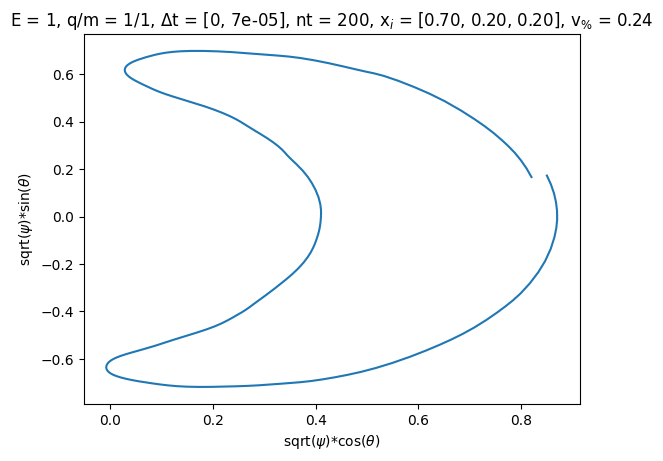

In [10]:
plt.plot(np.sqrt(sol[:, 0]) * np.cos(sol[:, 1]), np.sqrt(sol[:, 0]) * np.sin(sol[:, 1]))
plt.xlabel(r'sqrt($\psi$)*cos($\theta$)')
plt.ylabel(r'sqrt($\psi$)*sin($\theta$)')
plt.title(rf'E = {E_}, q/m = {q_}/{m_}, $\Delta$t = [{t_i}, {t_f}], nt = {nt_}, x$_i$ = [{psi_i:.2f}, {theta_i:.2f}, {zeta_i:.2f}], v$_\%$ = {vpar_i_ratio:.2f}')
plt.show()

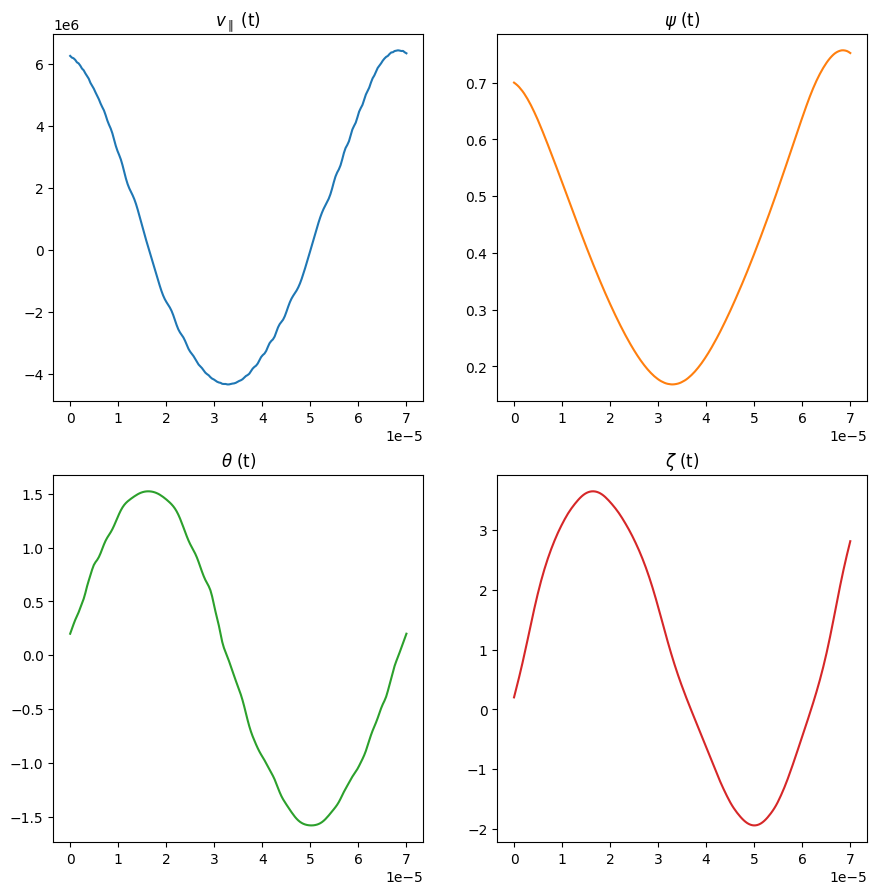

In [11]:
t = np.linspace(t_i, t_f, nt_)
fig, axs = plt.subplots(2, 2)
axs[0, 1].plot(t, sol[:, 0], 'tab:orange')
axs[0, 1].set_title(r'$\psi$ (t)')
axs[1, 0].plot(t, sol[:, 1], 'tab:green')
axs[1, 0].set_title(r'$\theta$ (t)')
axs[1, 1].plot(t, sol[:, 2], 'tab:red')
axs[1, 1].set_title(r'$\zeta$ (t)')
axs[0, 0].plot(t, sol[:, 3], 'tab:blue')
axs[0, 0].set_title(r"$v_{\parallel}$ (t)")

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

[5.63200000e-13 5.63199485e-13 5.63199896e-13 5.63199787e-13
 5.63199285e-13 5.63199451e-13 5.63199415e-13 5.63199400e-13
 5.63199325e-13 5.63199283e-13 5.63198951e-13 5.63198624e-13
 5.63198716e-13 5.63198469e-13 5.63198377e-13 5.63198375e-13
 5.63198232e-13 5.63198094e-13 5.63197971e-13 5.63198527e-13
 5.63199417e-13 5.63199009e-13 5.63197556e-13 5.63196673e-13
 5.63196394e-13 5.63195591e-13 5.63194194e-13 5.63193578e-13
 5.63194742e-13 5.63196947e-13 5.63198357e-13 5.63197820e-13
 5.63195737e-13 5.63193380e-13 5.63191731e-13 5.63191037e-13
 5.63190967e-13 5.63190983e-13 5.63190642e-13 5.63189786e-13
 5.63188494e-13 5.63186970e-13 5.63185407e-13 5.63183922e-13
 5.63182555e-13 5.63181298e-13 5.63180115e-13 5.63178961e-13
 5.63177788e-13 5.63176550e-13 5.63175213e-13 5.63173764e-13
 5.63172224e-13 5.63170678e-13 5.63169272e-13 5.63168197e-13
 5.63167599e-13 5.63167484e-13 5.63167640e-13 5.63167684e-13
 5.63167212e-13 5.63166017e-13 5.63164317e-13 5.63162833e-13
 5.63162499e-13 5.631637

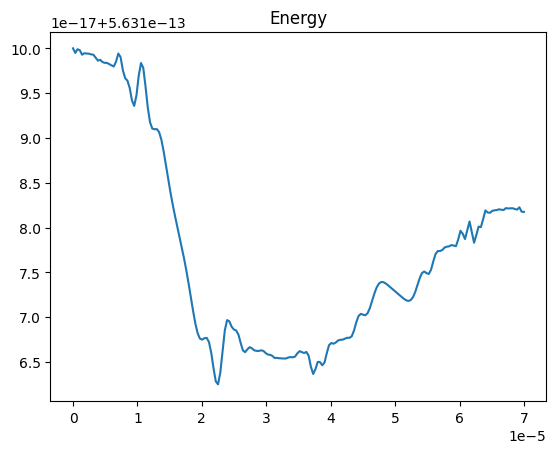

In [12]:

grid = Grid(np.vstack((np.sqrt(sol[:, 0]), sol[:, 1], sol[:, 2])).T,sort=False)
B_field = eq.compute("|B|", grid=grid)
Energy = 0.5*(sol[:, 3]**2 + 2*B_field["|B|"]*mu)*m_*1.673e-27
plt.plot(t, Energy)
plt.title("Energy")
print(Energy)

In [15]:
grid = Grid(np.vstack((np.sqrt(sol[:, 0]), sol[:, 1], sol[:, 2])).T,sort=False)
print(sol[:, 3].shape)
sys = eq.compute(["psidot", "thetadot", "zetadot", "vpardot"], grid=grid, mu = mu, vpar = sol[:, 3], m_q = 1.673e-27/1.6e-19)
print(sys["psidot"])



(200,)
[27857.61959624 27744.09810266 27696.69382576 27589.46582455
 27429.17345043 27360.03183634 27213.41842234 27030.80294267
 26925.49467646 26738.08781231 26576.14870705 26427.08047646
 26193.99335585 26039.36746166 25880.13981819 25688.45856224
 25516.76261269 25348.4267607  25150.27031159 24986.7580601
 24840.50982791 24638.84021227 24423.86075806 24258.4536308
 24117.342807   23944.01592477 23735.71169033 23540.32151813
 23391.24350238 23275.17117745 23154.65948446 23009.83862316
 22855.09558951 22717.46485814 22611.48089139 22534.87210606
 22476.09043126 22422.12279064 22364.06503206 22299.98306084
 22233.92495021 22172.07778869 22119.24194476 22077.59531799
 22047.26452849 22027.3991394  22016.99185965 22015.3108479
 22022.05695379 22037.3566726  22061.62260805 22095.23949831
 22138.01526241 22188.44848079 22243.17489866 22297.31750906
 22346.30668816 22388.58422516 22427.35090925 22469.93600918
 22525.12617144 22599.46114551 22692.8769509  22795.19324245
 22888.71852783 2296

In [17]:
system([sol[-1, 0], sol[-1, 1], sol[-1, 2], sol[-1, 3]], t, [mu, 1.673e-27/1.6e-19, bound_psi])

[6.34197411e+13]


Array([[-6.28762000e+03],
       [ 1.25753948e+05],
       [ 3.17074717e+05],
       [-3.72950162e+10]], dtype=float64)